#TTCD: Transformer Integrated Temporal Causal Discovery from Non-Stationary Time Series Data (Arctic Sea Ice Dataset)


This notebook contains the proposed TTCD model. The proposed model consists of a Non-Staionary Feature Learner module and a Causal Structure learner module. Here we have integrated the transformer with non-stationary attention and the Causal Conv2D layer to generate a full causal graph from time series data.

In this notebook, we applied the proposed model to the real world Arctic Sea Ice dataset to generate a causal graph. The codes to visualize the predicted causal graph are available after the model training codes. The predicted graph is compared with ground truth using an adjacency matrix (array).   



##Non-Stationary Feature Learner Module

Following blocks contain code for transformer and non-stationary attention to learn non-stationary features.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import math
from math import sqrt
import torch.nn.functional as F



plt.switch_backend('agg')

class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                    torch.arange(H)[None, :, None],
                    index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask





def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj == 'type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch - 1) // 1))}
    elif args.lradj == 'type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))


class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss


class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


class StandardScaler():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def transform(self, data):
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean


def visual(true, preds=None, name='/content/pic/test.pdf'):
    """
    Results visualization
    """
    plt.figure()
    plt.plot(true, label='GroundTruth', linewidth=2)
    if preds is not None:
        plt.plot(preds, label='Prediction', linewidth=2)
    plt.legend()
    plt.savefig(name, bbox_inches='tight')






class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()

        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6, 'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.position_embedding(x)
        return self.dropout(x)


class DataEmbedding_wo_pos(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding_wo_pos, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark)
        return self.dropout(x)





class DSAttention(nn.Module):
    '''De-stationary Attention'''
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(DSAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        tau = 1.0 if tau is None else tau.unsqueeze(1).unsqueeze(1)  # B x 1 x 1 x 1
        delta = 0.0 if delta is None else delta.unsqueeze(1).unsqueeze(1)  # B x 1 x 1 x S

        # De-stationary Attention
        scores = torch.einsum("blhe,bshe->bhls", queries, keys) * tau + delta

        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)


class DSProbAttention(nn.Module):
    '''De-stationary ProbAttention for Informer'''
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(DSProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top):  # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k))  # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze()

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   M_top, :]  # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1))  # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else:  # use mask
            assert (L_Q == L_V)  # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1)  # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
        torch.arange(H)[None, :, None],
        index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V]) / L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2, 1)
        keys = keys.transpose(2, 1)
        values = values.transpose(2, 1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item()  # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item()  # c*ln(L_q)

        U_part = U_part if U_part < L_K else L_K
        u = u if u < L_Q else L_Q

        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)

        tau = 1.0 if tau is None else tau.unsqueeze(1).unsqueeze(1)  # B x 1 x 1 x 1
        delta = 0.0 if delta is None else delta.unsqueeze(1).unsqueeze(1)  # B x 1 x 1 x S
        scores_top = scores_top * tau + delta

        # add scale factor
        scale = self.scale or 1. / sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)

        return context.contiguous(), attn


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads

    def forward(self, queries, keys, values, attn_mask, tau=None, delta=None):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        #print("AttentionLayer (Q, K, V): ",queries.size(), keys.size(), values.size()) #OMAR

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask,
            tau, delta
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), attn





class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=2,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1)) # BxExS
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1, 2)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        new_x, attn = self.attention(
            x, x, x,
            attn_mask=attn_mask,
            tau=tau, delta=delta
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn


class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None, tau=None, delta=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for i, (attn_layer, conv_layer) in enumerate(zip(self.attn_layers, self.conv_layers)):
                delta = delta if i==0 else None
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, tau=tau, delta=None)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask, tau=tau, delta=delta)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns


class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):

        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask,
            tau=tau, delta=None
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask,
            tau=tau, delta=delta
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm3(x + y)


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None, tau=None, delta=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask, tau=tau, delta=delta)

        if self.norm is not None:
            x = self.norm(x)

        if self.projection is not None:
            x = self.projection(x)
        return x




class DSFactors(nn.Module):
    '''
    MLP to learn the De-stationary factors
    '''
    def __init__(self, enc_in, seq_len, hidden_dims, hidden_layers, output_dim, kernel_size=3):
        super(DSFactors, self).__init__()

        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.series_conv = nn.Conv1d(in_channels=seq_len, out_channels=1, kernel_size=kernel_size, padding=padding, padding_mode='circular', bias=False)

        layers = [nn.Linear(2 * enc_in, hidden_dims[0]), nn.ReLU()]
        for i in range(hidden_layers-1):
            layers += [nn.Linear(hidden_dims[i], hidden_dims[i+1]), nn.ReLU()]

        layers += [nn.Linear(hidden_dims[-1], output_dim, bias=False)]
        self.backbone = nn.Sequential(*layers)

    def forward(self, x, stats):
        # x:     B x S x E
        # stats: B x 1 x E
        # y:     B x O
        batch_size = x.shape[0]
        x = self.series_conv(x)          # B x 1 x E
        x = torch.cat([x, stats], dim=1) # B x 2 x E
        x = x.view(batch_size, -1) # B x 2E
        y = self.backbone(x)       # B x O

        return y



In [2]:
class NSTransformer(nn.Module):
    """
    Non-stationary Transformer
    """
    def __init__(self, configs):
        super(NSTransformer, self).__init__()
        self.pred_len = configs.pred_len
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.output_attention = configs.output_attention

        # Embedding
        self.enc_embedding = DataEmbedding(configs.enc_in, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout)
        self.dec_embedding = DataEmbedding(configs.dec_in, configs.d_model, configs.embed, configs.freq,
                                           configs.dropout)
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        DSAttention(False, configs.factor, attention_dropout=configs.dropout,
                                      output_attention=configs.output_attention), configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation
                ) for l in range(configs.e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(
                        DSAttention(True, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads),
                    AttentionLayer(
                        DSAttention(False, configs.factor, attention_dropout=configs.dropout, output_attention=False),
                        configs.d_model, configs.n_heads),
                    configs.d_model,
                    configs.d_ff,
                    dropout=configs.dropout,
                    activation=configs.activation,
                )
                for l in range(configs.d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(configs.d_model),
            projection=nn.Linear(configs.d_model, configs.c_out, bias=True)
        )

        self.tau_learner   = DSFactors(enc_in=configs.enc_in, seq_len=configs.seq_len, hidden_dims=configs.p_hidden_dims, hidden_layers=configs.p_hidden_layers, output_dim=1)
        self.delta_learner = DSFactors(enc_in=configs.enc_in, seq_len=configs.seq_len, hidden_dims=configs.p_hidden_dims, hidden_layers=configs.p_hidden_layers, output_dim=configs.seq_len)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):

        x_raw = x_enc.clone().detach()

        # Normalization
        mean_enc = x_enc.mean(1, keepdim=True).detach() # B x 1 x E
        x_enc = x_enc - mean_enc
        std_enc = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5).detach() # B x 1 x E
        x_enc = x_enc / std_enc
        x_dec_new = torch.cat([x_enc[:, -self.label_len: , :], torch.zeros_like(x_dec[:, -self.pred_len:, :])], dim=1).to(x_enc.device).clone()

        tau = self.tau_learner(x_raw, std_enc).exp()     # B x S x E, B x 1 x E -> B x 1, positive scalar
        delta = self.delta_learner(x_raw, mean_enc)      # B x S x E, B x 1 x E -> B x S

        # Model Inference
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask, tau=tau, delta=delta)

        dec_out = self.dec_embedding(x_dec_new, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask, tau=tau, delta=delta)

        # De-normalization
        dec_out1 = dec_out * std_enc + mean_enc

        if self.output_attention:
            #Return all predictions with previous and future values
            return dec_out1[:, :, :], dec_out, attns
        else:
            return dec_out1[:, :, :], dec_out  # [B, L, D]

##Data Loader

In [3]:
import numpy as np
import pandas as pd


df_2D_data_sea_ice = pd.read_csv('/content/Arctic_Sea_Ice_Data_1980_2018.csv')
df_2D_data_sea_ice.columns = ['HFLX','SW','LW','SLP', 'PRE','RH','U10m', 'V10m', 'ICE', 'CC', 'CW','GH']
df_2D_data_sea_ice = df_2D_data_sea_ice[['HFLX','CC','SW','U10m','SLP', 'PRE','ICE', 'LW','V10m','CW','GH','RH']]
df_2D_data_sea_ice.to_csv('Sea_Ice_Data.csv', index=False)

In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import warnings
import os

warnings.filterwarnings('ignore')



class Dataset_Custom(Dataset):
    def __init__(self, root_path, flag='train', size=None,
                 features='S', data_path='Sea_Ice_Data.csv',
                 target='OT', scale=True, timeenc=0, freq='h'):
        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            self.seq_len = 24 * 4 * 4
            self.label_len = 24 * 4
            self.pred_len = 24 * 4
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'test', 'val']
        type_map = {'train': 0, 'val': 1, 'test': 2}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq

        self.root_path = root_path
        self.data_path = data_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = pd.read_csv(os.path.join(self.root_path,
                                          self.data_path))

        cols = list(df_raw.columns)
        print(cols)
        num_train = int(len(df_raw) * 0.7)
        num_test = int(len(df_raw) * 0.15)
        num_vali = len(df_raw) - num_train - num_test
        border1s = [0, num_train - self.seq_len, len(df_raw) - num_test - self.seq_len]
        border2s = [num_train, num_train + num_vali, len(df_raw)]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]

        df_data = df_raw

        if self.scale:
            train_data = df_data[border1s[0]:border2s[0]]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values


        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        #self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = " "
        seq_y_mark = " "

        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)



data_dict = {
    'custom': Dataset_Custom,
}


def data_provider(args, flag):
    Data = data_dict[args.data]
    timeenc = 0 if args.embed != 'timeF' else 1

    if flag == 'test':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = args.freq
    else:
        shuffle_flag = True
        drop_last = True
        batch_size = args.batch_size
        freq = args.freq

    data_set = Data(
        root_path=args.root_path,
        data_path=args.data_path,
        flag=flag,
        size=[args.seq_len, args.label_len, args.pred_len],
        features=args.features,
        target=args.target,
        timeenc=timeenc,
        freq=freq
    )
    print(flag, len(data_set))
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=args.num_workers,
        drop_last=drop_last)
    return data_set, data_loader

##Causal Structure Learner Module

In [5]:
import random



class Parameters_all:
    def __init__(self):
        self.is_training = 1
        self.model_id = 'test'
        self.model = 'ns_Transformer'
        # data loader
        self.data = 'custom'
        self.root_path ='/content/'
        self.data_path = 'Sea_Ice_Data.csv'
        self.features = 'M'
        self.target = 'OT'
        self.freq = 'h'
        self.checkpoints = '/content/checkpoints/'

        # forecasting task
        self.seq_len = 13       #input sequence length
        self.label_len = 13     #start token length
        self.pred_len = 13      #prediction sequence length

        # model define
        self.enc_in = 12       #encoder input size
        self.dec_in = 12       #decoder input size
        self.c_out = 12        #output size
        self.d_model = 64      #dimension of model
        self.n_heads = 4       #num of attention heads
        self.d_layers = 4      #num of decoder layers
        self.e_layers = 4      #num of encoder layers
        self.d_ff = 128        #dimension of fcn
        self.factor = 1       #attn factor
        self.distil = True
        self.dropout = 0.05
        self.embed ='timeF'
        self.activation = 'gelu'
        self.output_attention = True #whether to output attention in encoder
        self.do_predict = True       #whether to predict unseen future data

        # optimization
        self.num_workers=1          #data loader num workers
        self.itr= 1                 #experiments times
        self.train_epochs = 10      #train epochs
        self.batch_size= 128        #batch size of train input data
        self.patience = 3           #early stopping patience
        self.learning_rate = 0.0001 #optimizer learning rate
        self.des ='test'
        self.loss ='mse'
        self.lradj ='type1'        #adjust learning rate
        self.use_amp = False       #use automatic mixed precision training

        # GPU
        self.use_gpu = False
        self.gpu = 0
        self.use_multi_gpu = False #use multiple gpus
        self.devices ='0,1,2,3'    #device ids of multile gpus
        self.seed = 2021

        # de-stationary projector params
        self.p_hidden_dims = [64, 64] #hidden layer dimensions of projector (List)
        self.p_hidden_layers = 2      #number of hidden layers in projector



args = Parameters_all()


#create these folders
!mkdir results
!mkdir test_results
!mkdir pic
!mkdir checkpoints


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
from torchsummary import summary


# Custom Causal Conv2D Layer
class CausalConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, counter, kernel_size=(1, 1), padding='valid', activation="tanh"):
        super(CausalConv2D, self).__init__()
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, padding=0 if padding == 'valid' else 1)
        self.counter = counter
        self.mask = None
        self.activation = nn.Tanh() if activation == "tanh" else nn.ReLU()

    def forward(self, x):
        if self.mask is None:
            self.mask = torch.ones_like(self.conv2d.weight)
            self.mask[0,0,self.counter, -1] = 0.0
        self.conv2d.weight.data.mul_(self.mask)
        return self.activation(self.conv2d(x))



# Causal Model Definition
class CausalModel2D(nn.Module):
    def __init__(self, args, input_dims):
        super(CausalModel2D, self).__init__()
        self.args = args
        self.activation = nn.ReLU()
        self.model = NSTransformer(self.args).float()
        self.pooled_outputs = nn.ModuleList([CausalConv2D(1, 1, i, kernel_size=(12, 13), activation="relu") for i in range(12)])

    def forward(self, batch_x, batch_x_mark, dec_inp, batch_y_mark):
        if self.args.output_attention:
          x, x1 = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0:2]
        else:
          x, x1 = self.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0:2]

        y = x1[:, :self.args.pred_len, :]
        y = y.permute(0,2,1).unsqueeze(1)
        pooled_outputs = [layer(y) for layer in self.pooled_outputs]
        y = torch.cat(pooled_outputs, dim=1)
        y = y.view(y.size(0), -1)
        return x, x1, y


##TTCD Model

In [7]:
# Overall TTDC Model Definition
class TTDCModel(nn.Module):
    def __init__(self, args, dims, alpha=1.0, rho=1.0, rho_max=10e20, h_tol=1e-8):
        super(TTDCModel, self).__init__()
        self.args = args
        self.dims = dims
        self.alpha = alpha
        self.rho = rho
        self.h_p = float('inf')
        self.rho_max = rho_max
        self.h_tol = h_tol
        self.model_2d = CausalModel2D(self.args, self.dims)
        if self.args.use_gpu:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(
                self.args.gpu) if not self.args.use_multi_gpu else self.args.devices
            self.device = torch.device('cuda:{}'.format(self.args.gpu))
            print('Use GPU: cuda:{}'.format(self.args.gpu))
        else:
            self.device = torch.device('cpu')
            print('Use CPU')

    def forward(self, batch_x, batch_x_mark, dec_inp, batch_y_mark):
        return self.model_2d(batch_x, batch_x_mark, dec_inp, batch_y_mark)

    def _get_data(self, flag):
        data_set, data_loader = data_provider(self.args, flag)
        return data_set, data_loader

    def _select_criterion(self):
        criterion = nn.MSELoss()
        return criterion

    def loss_function(self, true_1, pred_1, true_2, pred_2):
      reconstruction_loss = nn.MSELoss()(true_1, pred_1)
      print(f'Reconstruction Loss is: {reconstruction_loss}')
      custom_loss = self.custom_loss_function(true_2, pred_2)
      total_loss = 0.4 * reconstruction_loss + 0.6 * custom_loss
      #return custom_loss
      return total_loss

    def custom_loss_function(self, y_true, y_pred):
        mse = nn.MSELoss()(y_pred, y_true)
        h_val = self.causal_loss_h()
        h_loss = 0.5 * self.rho * h_val * h_val + self.alpha * h_val
        lambda1 = 0.9
        adj_mat = self.get_mat()
        sparse_loss = lambda1 * np.sum(np.absolute(adj_mat))
        print(f'MSE Loss is: {mse}, h Loss is: {h_loss}, L1 loss: {sparse_loss}, Total Loss is: {mse + h_loss + sparse_loss}')
        return mse + h_loss + sparse_loss

    def causal_loss_h(self):
        mat = self.get_mat()
        h_val = self.h_acy(mat[:, 144:])
        return h_val

    def get_mat(self):
        # Assuming `self.model_2d` has 4 causal conv layers
        conv_layers = [layer for layer in self.model_2d.pooled_outputs]
        weights = [layer.conv2d.weight.data.cpu().numpy().flatten('F') for layer in conv_layers]
        mat_2d_s = np.stack(weights)
        return mat_2d_s

    def h_acy(self, A):
        n_var = A.shape[0]
        AT = torch.tensor(A, dtype=torch.float32)
        h = torch.trace(torch.linalg.matrix_exp(AT * AT)) - n_var
        return h

    def compile(self, optimizer='adam'):
        self.optimizer = optim.Adam(self.parameters(), lr=self.args.learning_rate) if optimizer == 'adam' else optim.SGD(self.parameters(), lr=1e-2)

    def fit(self, maxiter=100, batch_size=512, save_dir='./results/temp'):
        start_time = time.time()

        train_data, train_loader = self._get_data(flag='train')
        early_stopping = EarlyStopping(patience=self.args.patience, verbose=True)
        criterion = self._select_criterion()
        train_loss = []

        for epoch in range(maxiter):
            print(f'Epoch: {epoch}')
            train_loss = []
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):

                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -self.args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :self.args.label_len, :], dec_inp], dim=1).float().to(self.device)

                self.optimizer.zero_grad()

                output_a, output_a1, output_b  = self.forward(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                output_a = output_a[:, :self.args.pred_len, :]
                batch_y_1 = batch_y[:, :self.args.pred_len, :].to(self.device)

                batch_y_2 = batch_y[:, self.args.pred_len-1, :].to(self.device)
                output_a1 = output_a1[:, self.args.pred_len-1, :]

                print(f'Output A shape is: {output_a.shape}, Output B shape is: {output_b.shape}, Y1 shape is: {batch_y_1.shape}, Y2 shape is: {batch_y_2.shape}')

                loss = self.loss_function(batch_y_1, output_a, output_a1, output_b)
                train_loss.append(loss.item())
                loss.backward()
                self.optimizer.step()



        #log_file.close()
        torch.save(self.state_dict(), f"{save_dir}/CausalNN_model_final_{round(time.time())}.pt")


        adj_mat = self.get_mat()

        return adj_mat

##Training the Proposed Model

In [25]:
torch.manual_seed(1001)


ttdcmodel = TTDCModel(args, dims=(1, 4, 6))
ttdcmodel.compile(optimizer='SGD')

mat = ttdcmodel.fit(maxiter=200, batch_size=128, save_dir='/content/')

Use CPU
['HFLX', 'CC', 'SW', 'U10m', 'SLP', 'PRE', 'ICE', 'LW', 'V10m', 'CW', 'GH', 'RH']
train 302
Epoch: 0
Output A shape is: torch.Size([128, 13, 12]), Output B shape is: torch.Size([128, 12]), Y1 shape is: torch.Size([128, 13, 12]), Y2 shape is: torch.Size([128, 12])
Reconstruction Loss is: 1.3716992139816284
MSE Loss is: 0.29771286249160767, h Loss is: 0.00028328137705102563, L1 loss: 69.4378646850586, Total Loss is: 69.7358627319336
Output A shape is: torch.Size([128, 13, 12]), Output B shape is: torch.Size([128, 12]), Y1 shape is: torch.Size([128, 13, 12]), Y2 shape is: torch.Size([128, 12])
Reconstruction Loss is: 1.3298108577728271
MSE Loss is: 0.24870310723781586, h Loss is: 0.00028328137705102563, L1 loss: 69.43471984863281, Total Loss is: 69.68370819091797
Epoch: 1
Output A shape is: torch.Size([128, 13, 12]), Output B shape is: torch.Size([128, 12]), Y1 shape is: torch.Size([128, 13, 12]), Y2 shape is: torch.Size([128, 12])
Reconstruction Loss is: 1.2748844623565674
MSE Lo

##Causal Graph

In [27]:
matrix_2d_2d_s = mat

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
G_2d_s1 = nx.DiGraph()

nodes_2d_s = ['HFLX', 'CC', 'SW', 'U10m', 'SLP', 'PRE', 'ICE', 'LW', 'V10m', 'CW','GH', 'RH']
nodes_r_2d_s = ['HFLX', 'CC', 'SW', 'U10m', 'SLP', 'PRE', 'ICE', 'LW', 'V10m', 'CW','GH', 'RH']
edges_2d_s1 = []
pred_graph_s1 = np.zeros((12,12))

In [29]:
for i in range (0, 12):
  G_2d_s1.add_node(nodes_2d_s[i],pos=(int(i/3)+1,(i%3)+1))

In [30]:
count=0
for i in range(0, 156):
  for j in range (0, 12):
    if matrix_2d_2d_s[j,i] > 0.075:
      col = np.round(matrix_2d_2d_s[j,i], 2)
      print(i,j, matrix_2d_2d_s[j,i])
      G_2d_s1.add_edge(nodes_2d_s[i%12], nodes_r_2d_s[j], weight=col)
      pred_graph_s1[i%12, j]=1
      count+=1


7 0 0.07523809
8 9 0.080759466
13 8 0.082135566
19 4 0.075673245
21 5 0.07815995
22 10 0.0768313
25 1 0.07866818
25 5 0.07882675
28 3 0.07755905
29 0 0.07800066
29 5 0.07539408
29 6 0.08315956
32 8 0.07782786
33 2 0.07978702
37 7 0.08815878
37 9 0.08644389
40 1 0.07716357
47 9 0.076320596
49 8 0.07650823
60 5 0.086263075
62 4 0.07637581
64 0 0.07689351
64 5 0.07715497
64 10 0.07818334
66 8 0.078440204
70 8 0.07891145
73 7 0.08234583
78 10 0.08076305
79 6 0.08469185
79 8 0.08117472
84 4 0.07588663
87 10 0.07977636
88 1 0.07576309
91 3 0.07615034
97 2 0.07640599
102 10 0.07982358
105 0 0.0766066
120 11 0.075105175
122 0 0.07708748
124 3 0.07502981
127 0 0.07599301
132 6 0.08378265
133 3 0.07841493
136 6 0.07713787
137 1 0.084842265
138 4 0.08206104
141 5 0.09183357
141 9 0.07708971
142 8 0.07776937
144 6 0.07623322
148 0 0.07658647


In [31]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'HFLX': (1, 1),
 'CC': (1, 2),
 'SW': (1, 3),
 'U10m': (2, 1),
 'SLP': (2, 2),
 'PRE': (2, 3),
 'ICE': (3, 1),
 'LW': (3, 2),
 'V10m': (3, 3),
 'CW': (4, 1),
 'GH': (4, 2),
 'RH': (4, 3)}

In [32]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

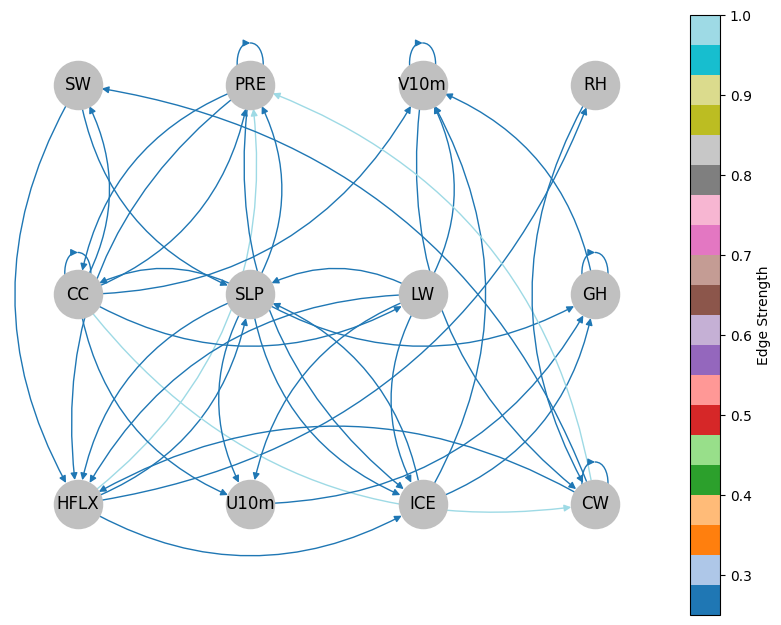

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(8, 6))
nx.draw(G_2d_s1, pos_2d_s1,  edge_cmap= plt.cm.tab20,  #cmap = plt.get_cmap('jet'),
        font_size=12, node_size=1200, node_color='#c0c0c0', #[30,30,30,30,30],
        edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.25, 1), cmap=plt.cm.tab20),
              orientation='vertical', label='Edge Strength')
plt.show()

In [35]:
true_graph = np.zeros((12,12))
true_graph[0,5]=1
true_graph[0,6]=1
true_graph[0,9]=1
true_graph[0,1]=1
true_graph[0,4]=1
true_graph[0,3]=1
true_graph[0,8]=1

true_graph[1,2]=1
true_graph[1,7]=1
true_graph[1,11]=1
true_graph[1,0]=1

true_graph[2,6]=1

true_graph[3,6]=1
true_graph[3,0]=1

true_graph[4,3]=1
true_graph[4,8]=1
true_graph[4,0]=1
true_graph[4,6]=1
true_graph[4,10]=1
true_graph[4,11]=1

true_graph[5,9]=1
true_graph[5,1]=1
true_graph[5,6]=1
true_graph[5,11]=1
true_graph[5,0]=1

true_graph[6,0]=1
true_graph[6,2]=1
true_graph[6,7]=1
true_graph[6,4]=1
true_graph[6,3]=1
true_graph[6,8]=1

true_graph[7,6]=1

true_graph[8,0]=1
true_graph[8,6]=1

true_graph[9,0]=1
true_graph[9,2]=1
true_graph[9,7]=1
true_graph[9,11]=1
true_graph[9,5]=1

true_graph[10,11]=1
true_graph[10,4]=1
true_graph[10,7]=1

true_graph[11,5]=1
true_graph[11,7]=1
true_graph[11,1]=1
true_graph[11,9]=1

true_graph

array([[0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]])

In [36]:
pred_graph_s1

array([[0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [21]:
!pip install cdt

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 12.6 MB/s eta 0:00:00
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=6e63a5b8233901122c18d553dcb368db408899a5a502579f514ef232e7132241
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=f13a541f0f1e153adda91818840a6843b67b608363546fdae6e8dc272e0c4cfa
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [22]:
import cdt

In [37]:
cdt.metrics.SHD(true_graph, pred_graph_s1)

49.0

In [38]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.6597222222222222, Precision: 0.4634146341463415, Recall: 0.41304347826086957, FDR: 0.5365853658536586, F1 Score: 0.4367816091954023
